## **Personalities (WIP Title)**
### A better way to get big five personalities

Data source:
https://www.kaggle.com/tunguz/big-five-personality-test

After reconstructing the autoencoder with 5 latent nodes, the challenge is to interpret the meaning of each node. For our purpose, we can reformulate the question to be the following: if we completely disconnect one of the 5 latent nodes in the last layer of the encoder and holding all other weights constant, the predicted values of which questions would be impacted the most?

To answer this, we need to do the following:

1. Have a baseline prediction using the trained model with all 5 latent nodes.
2. Remove one of the latent nodes, reconstruct the model and fill in the weights.
3. Make predictions with the reconstructed model with the missing latent node using the data.
4. Get the element-wise difference between the baseline prediction and new predictions.
5. Sum the predictions by question to get total difference per question. Record the numbers.
6. Repeat 2 until each of all the latent nodes have been removed once.
7. Find out which nodes have the biggest impact on which questions.
8. Given the content of the questions, we can interpret the effect of each of the nodes.

For example, if removing node 1 impacts mostly the questions related to aggression, then we can interpret that node 1 is mostly a measure of aggression.

This idea is similar to using PCA and clustering to get at latent dimensions, but with the advantage of having a more realistic model that allows for graph-like structure, which can more effectively mimic the real-world mechanisms of how the idea of personality traits lead to different answers. This structure is similar to what you would have gotten with bayesian-network but with a different way to get at the weights.

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Layer, Concatenate, Lambda, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

/home/roblee/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roblee/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roblee/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/roblee/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [93]:
# The following have to match training script exactly
input_dim = 50
layer_dim = 128
encoder_dim = 4
dropout_rate = 0.1
learning_rate = 0.001
activ_func = 'tanh'
activ_func_latent = 'sigmoid'
wgt_fp = "2020-05-16 19-10"

In [82]:
# load the model and see if we can extract the weights

def reconstruct_ae(input_dim, layer_dim, encoder_dim, dropout_rate, activation_func, wgt_fp, load_wgts = True):
    
    global activ_func_latent

    # Encoder
    input_encoder = Input(shape=(input_dim, ))
    encoder1 = Dense(layer_dim, activation=activation_func)(input_encoder)
    e_bnorm1 = BatchNormalization(axis=1)(encoder1)
    e_dropout1 = Dropout(dropout_rate)(e_bnorm1)
    encoder2 = Dense(layer_dim, activation=activation_func)(e_dropout1)
    e_bnorm2 = BatchNormalization(axis=1)(encoder2)
    e_dropout2 = Dropout(dropout_rate)(e_bnorm2)
    encoder3 = Dense(layer_dim, activation=activation_func)(e_dropout2)
    e_bnorm3 = BatchNormalization(axis=1)(encoder3)
    e_dropout3 = Dropout(dropout_rate)(e_bnorm3)
    output_encoder = Dense(encoder_dim, activation=activ_func_latent)(e_dropout3)

    # Decoder
    input_decoder = Input(shape=(encoder_dim, ))
    decoder1 = Dense(layer_dim, activation=activation_func)(input_decoder)
    d_bnorm1 = BatchNormalization(axis=1)(decoder1)
    d_dropout1 = Dropout(dropout_rate)(d_bnorm1)
    decoder2 = Dense(layer_dim, activation=activation_func)(d_dropout1)
    d_bnorm2 = BatchNormalization(axis=1)(decoder2)
    d_dropout2 = Dropout(dropout_rate)(d_bnorm2)
    decoder3 = Dense(layer_dim, activation=activation_func)(d_dropout2)
    d_bnorm3 = BatchNormalization(axis=1)(decoder3)
    d_dropout3 = Dropout(dropout_rate)(d_bnorm3)
    output_decoder = Dense(input_dim, activation=activation_func)(d_dropout3)

    encoder = Model(inputs=input_encoder, outputs=output_encoder, name='encoder')
    decoder = Model(inputs=input_decoder, outputs=output_decoder)
    autoencoder = Model(inputs=input_encoder, outputs=decoder(encoder(input_encoder)), name='ae')

    if load_wgts:
        encoder.load_weights("models/" + wgt_fp + "/encoder_model.h5")
        autoencoder.load_weights("models/" + wgt_fp + "/ae_model.h5")

    return encoder, autoencoder

In [94]:
encoder_model, ae_model = reconstruct_ae(input_dim, layer_dim, encoder_dim, dropout_rate, activ_func, wgt_fp)

In [28]:
data = pd.read_csv("data/data_complete_only.csv")

In [42]:
# load in questions

with open("data/question_list.txt") as f:
    questions = f.readlines()
questions = [x.strip() for x in questions]

In [34]:
def interpret_latent_layer(data, input_dim, latent_dim, activation_func, dropout_rate, ae_model):
    """
    returns reconstruction loss for each question if one of latent dim is taken out
    """
    n_questions = input_dim 
    output = np.zeros((latent_dim, n_questions))
    
    pred = ae_model.predict(data.values)
    
    enc_len = len(ae_model.layers[1].layers)
    dec_len = len(ae_model.layers[2].layers)
    
    for i in range(latent_dim):
        # get rid of ith column
        selected_cols = list(set(range(latent_dim)) - set([i]))
        # reconstruct model with one less num of dim in encoder output
        _, ae_model_recon = reconstruct_ae(n_questions, layer_dim, latent_dim-1, dropout_rate, activation_func, [], False)
        # set the weights manually for encoder layers 1-9
        for lyr in range(1,enc_len-1):
            ae_model_recon.layers[1].layers[i].set_weights(ae_model.layers[1].layers[i].get_weights())
        # modify weight dim for the last layer of encoder
        wghts_mod_1 = []
        wghts_mod_1.append(ae_model.layers[1].layers[-1].get_weights()[0][:,selected_cols])
        wghts_mod_1.append(ae_model.layers[1].layers[-1].get_weights()[1][selected_cols])
        ae_model_recon.layers[1].layers[-1].set_weights(wghts_mod_1)
        # modify weights again for the first layer of decoder
        wghts_mod_2 = []
        wghts_mod_2.append(ae_model.layers[2].layers[1].get_weights()[0][selected_cols,:])
        wghts_mod_2.append(ae_model.layers[2].layers[1].get_weights()[1])
        ae_model_recon.layers[2].layers[1].set_weights(wghts_mod_2)
        # set weights manually for layers 2-11 in decoder
        for lyr in range(2,dec_len):
            ae_model_recon.layers[2].layers[lyr].set_weights(ae_model.layers[2].layers[lyr].get_weights())
        
        # calculate total squared error loss for each question
        pred_recon = ae_model_recon.predict(data.values)
        output[i] = np.square(pred - pred_recon).sum(axis=0)
    
    return output

In [95]:
answer_loss = interpret_latent_layer(data, input_dim, encoder_dim, activ_func, dropout_rate, ae_model)

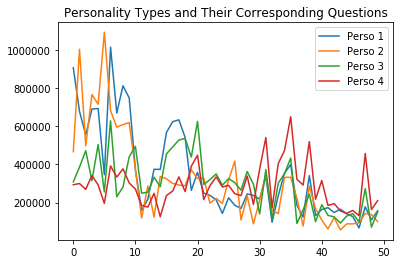

In [96]:
# let's plot this as line graph
for i in range(encoder_dim):
    plt.plot(answer_loss[i], label="Perso %i" % (i+1))
plt.legend()
plt.title("Personality Types and Their Corresponding Questions")
model_fp = "models/" + wgt_fp
plt.savefig(model_fp + "/perso_types.png")

In [97]:
question_dict = dict(zip(range(len(questions)), questions))

In [98]:
# Get top questions for each perso type

answer_loss_df = pd.DataFrame(answer_loss.T)

In [99]:
# For each perso get top 10 questions

top_10_q = []

for perso in range(answer_loss_df.shape[1]):
    top_10_q.append(list(answer_loss_df.iloc[:,perso].sort_values(ascending=False)[:10].index))

In [100]:
top_10_dict = {}

for p in range(answer_loss_df.shape[1]):
    top_10_dict[p] = [question_dict[i] for i in top_10_q[p]]

In [101]:
top_10_dict

{0: ['I talk to a lot of different people at parties.',
  'I am the life of the party.',
  "I don't mind being the center of attention.",
  'I am quiet around strangers.',
  'I start conversations.',
  'I keep in the background.',
  "I don't talk a lot.",
  "I don't like to draw attention to myself.",
  'I have frequent mood swings.',
  'I change my mood a lot.'],
 1: ['I have little to say.',
  "I don't talk a lot.",
  'I keep in the background.',
  'I start conversations.',
  'I talk to a lot of different people at parties.',
  'I am quiet around strangers.',
  "I don't mind being the center of attention.",
  "I don't like to draw attention to myself.",
  'I feel comfortable around people.',
  'I am the life of the party.'],
 2: ['I talk to a lot of different people at parties.',
  'I feel little concern for others.',
  'I get irritated easily.',
  'I have frequent mood swings.',
  'I start conversations.',
  'I get stressed out easily.',
  'I change my mood a lot.',
  'I feel comfor